In [165]:
from collections import defaultdict
from wmdecompose.documents import Document
from wmdecompose.gale_shapeley import Matcher
from wmdecompose.models import LC_RWMD, WMD, WMDPairs
from wmdecompose.utils import *

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from random import shuffle
from scipy.spatial.distance import is_valid_dm, cdist
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import cluster

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import umap

%load_ext autoreload
%autoreload 2

random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Prepare IMDB data

### 1.1 Load data and stopwords.

In [50]:
%%time

PATH = "../data/yelp_dataset/"
yelp_data = []
r_dtypes = {"review_id":str,
            "user_id":str,
            "business_id":str,
            "stars": np.int32, 
            "date":str,
            "text":str,
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32}
drop = ['review_id', 'user_id', 'useful', 'funny', 'cool']
query = "date >= '2017-12-01' and (stars==1 or stars ==5)"

with open(f"{PATH}yelp_academic_dataset_review.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, dtype=r_dtypes, chunksize=1000)
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=drop).query(query)
        yelp_data.append(reduced_chunk)
    
yelp_data = pd.concat(yelp_data, ignore_index=True)


CPU times: user 2min 53s, sys: 10.1 s, total: 3min 3s
Wall time: 3min 7s


In [167]:
yelp_data.shape

(1948607, 4)

In [52]:
yelp_business = pd.read_json(f"{PATH}yelp_academic_dataset_business.json", orient="records", lines=True)
yelp_business.shape

(160585, 14)

In [53]:
yelp_business = yelp_business[yelp_business.city.isin(["Portland", "Atlanta"])]
yelp_business.shape

(30815, 14)

In [168]:
yelp_merged = yelp_data.merge(yelp_business, on='business_id')

In [169]:
yelp_merged.shape

(451826, 17)

In [170]:
yelp_merged = yelp_merged.rename(columns={"stars_x":"stars"})

In [171]:
categories = [c.split(",") for c in yelp_merged.categories if c is not None]

In [172]:
c_count = Counter(c.strip() for c_list in categories for c in set(c_list))
c_count.most_common()[:30]

[('Restaurants', 272644),
 ('Food', 125420),
 ('Nightlife', 97019),
 ('Bars', 92658),
 ('Breakfast & Brunch', 55588),
 ('American (New)', 51193),
 ('American (Traditional)', 45802),
 ('Shopping', 40107),
 ('Coffee & Tea', 35901),
 ('Event Planning & Services', 35797),
 ('Sandwiches', 35124),
 ('Beauty & Spas', 34342),
 ('Home Services', 27398),
 ('Cocktail Bars', 27397),
 ('Southern', 25006),
 ('Seafood', 22942),
 ('Health & Medical', 21841),
 ('Mexican', 21828),
 ('Burgers', 21287),
 ('Pizza', 19637),
 ('Desserts', 19446),
 ('Bakeries', 18827),
 ('Local Services', 18501),
 ('Vegan', 17800),
 ('Vegetarian', 17096),
 ('Hotels & Travel', 16855),
 ('Automotive', 16844),
 ('Asian Fusion', 16781),
 ('Salad', 16769),
 ('Wine & Spirits', 16370)]

In [173]:
yelp_categorized = yelp_merged.assign(categories=yelp_merged['categories'].str.split(',')).explode('categories')
yelp_categorized.categories = yelp_categorized.categories.str.strip()
yelp_categorized.shape

(2424116, 17)

In [174]:
yelp_filtered = yelp_categorized[yelp_categorized.categories.isin(['Restaurants','Health & Medical'])]
yelp_filtered.shape

(294485, 17)

In [176]:
s_size = 1000
rs = 42
sample = yelp_filtered.groupby(["stars", "categories"]).sample(n=s_size, random_state=rs).reset_index()
sample.shape

(4000, 18)

In [177]:
stopword_list=stopwords.words('english')

### 1.2 Remove special formatting and stopwords

In [178]:
tokenizer = ToktokTokenizer()

Remove stopwords before denoising, lemmatizing and removing special characters.

In [179]:
%%time 

sample['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in sample['text']]

CPU times: user 1.42 s, sys: 90.1 ms, total: 1.51 s
Wall time: 1.67 s


Denoise, remove special characters, lemmatize.

In [180]:
%%time

sample['review_clean']=sample['review_clean'].apply(denoise_text)
sample['review_clean']=sample['review_clean'].apply(remove_special_characters)
sample['review_clean']=sample['review_clean'].apply(simple_lemmatizer)

CPU times: user 1.14 s, sys: 54 ms, total: 1.19 s
Wall time: 1.24 s


Remove stopwords again, after other preprocessing.

In [181]:
%%time 

sample['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in sample['review_clean']]

CPU times: user 807 ms, sys: 10.2 ms, total: 818 ms
Wall time: 831 ms


Find phrases.

In [182]:
PHRASING = True
MIN = 500
THRESHOLD = 200

In [183]:
%%time

if PHRASING:
    sample['review_clean']= get_phrases([tokenizer.tokenize(i) for i in sample['review_clean']],
                                        min_count = MIN, 
                                        threshold = THRESHOLD,
                                        save=False,
                                        load=True,
                                        PATH="../embeddings/")

Finding bigrams in data.
Finding trigrams in data.
CPU times: user 17.5 s, sys: 4.7 s, total: 22.2 s
Wall time: 23.8 s


Data _before_ preprocessing and phrasing.

In [184]:
sample['text'][6]

"Very poor business practices and patient relations. Some doctors and offices treat you like a human and make you feel good about being a patient. This is not one of them. If you want a relationship with your doctor, a good experience, returned phone calls and professionalism, don't go here. Looks like I'm another reviewer heading to the GA Board of Dentistry......"

Data _after_ preprocessing and phrasing.

In [185]:
#sample['review_clean'][0]
" ".join(sample['review_clean'][6])

'poor business_practice patient relation doctor_office treat like human make feel good patient one want relationship doctor good experience returned phone_call professionalism go look like another_reviewer heading ga board_dentistry'

In [186]:
sample["sentiment"] = ['positive' if s == 5 else 'negative' for s in sample['stars']]

In [187]:
sample[["sentiment", "stars"]]

,sentiment,stars
0,negative,1
1,negative,1
2,negative,1
3,negative,1
4,negative,1
...,...,...
3995,positive,5
3996,positive,5
3997,positive,5
3998,positive,5


In [188]:
sample.head()

,index,business_id,stars,text,date,name,address,city,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,review_clean,sentiment
0,127548,yfYIxgJcjamxnztuDhitUg,1,"this place is a disaster, and I hate My doctor...",2019-04-25 14:34:31,Atlanta Center for Reproductive Medicine,"5909 Peachtree Dunwoody Rd, Ste 600",Atlanta,GA,30328,33.917085,-84.349500,2.5,86,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",Health & Medical,"{'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...","[place, disaster, hate, doctor, carpenter, nur...",negative
1,77717,Mpzv9m1f9qzl5UUHZyTemw,1,I've come here many times. It's hit or miss. T...,2019-12-02 03:38:21,Fly Dragon Spa,1928 NE 42nd Ave,Portland,OR,97213,45.536932,-122.619541,3.5,118,1,"{'BusinessParking': '{'garage': False, 'street...",Health & Medical,"{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...","[come, many, time, hit_miss, evening, male_mas...",negative
2,289181,Hb9O0Ox97v1uxCt77sLoMQ,1,DO NOT GO HERE UNLESS YOU WANT TO BE RIPPED OF...,2018-03-07 22:43:01,Zama Massage,2149 NE Broadway St,Portland,OR,97232,45.535209,-122.643698,4.5,468,1,"{'ByAppointmentOnly': 'False', 'BikeParking': ...",Health & Medical,"{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...","[go, unless, want, ripped, lied, immensely, di...",negative
3,127843,vOj3VF7l-aUPSHBmasgHPQ,1,uh. this place is definitely closed. boarded u...,2020-01-06 15:15:40,"Joseph Allen, DDS - JBM Dent",1336 Glenwood Ave SE,Atlanta,GA,30316,33.740468,-84.343748,4.5,6,0,{'ByAppointmentOnly': 'False'},Health & Medical,"{'Monday': '8:30-16:30', 'Tuesday': '8:30-16:3...","[uh, place, definitely, closed, boarded, windo...",negative
4,358414,2cqd12IDUfOwIBMXDxyy8Q,1,I had a first time appointment yesterday and u...,2019-01-17 03:26:01,Executive Park Dentistry,"17 Executive Park Dr NE, Ste 100",Atlanta,GA,30329,33.827726,-84.339213,4.5,44,1,"{'ByAppointmentOnly': 'True', 'WiFi': 'u'free'...",Health & Medical,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:0', '...","[first, time, appointment, yesterday, ultimate...",negative


In [191]:
sample_sorted = sample.sort_values(["sentiment", "categories"]).reset_index()

In [192]:
sample_sorted

,level_0,index,business_id,stars,text,date,name,address,city,state,...,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,review_clean,sentiment
0,0,127548,yfYIxgJcjamxnztuDhitUg,1,"this place is a disaster, and I hate My doctor...",2019-04-25 14:34:31,Atlanta Center for Reproductive Medicine,"5909 Peachtree Dunwoody Rd, Ste 600",Atlanta,GA,...,33.917085,-84.349500,2.5,86,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",Health & Medical,"{'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...","[place, disaster, hate, doctor, carpenter, nur...",negative
1,1,77717,Mpzv9m1f9qzl5UUHZyTemw,1,I've come here many times. It's hit or miss. T...,2019-12-02 03:38:21,Fly Dragon Spa,1928 NE 42nd Ave,Portland,OR,...,45.536932,-122.619541,3.5,118,1,"{'BusinessParking': '{'garage': False, 'street...",Health & Medical,"{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...","[come, many, time, hit_miss, evening, male_mas...",negative
2,2,289181,Hb9O0Ox97v1uxCt77sLoMQ,1,DO NOT GO HERE UNLESS YOU WANT TO BE RIPPED OF...,2018-03-07 22:43:01,Zama Massage,2149 NE Broadway St,Portland,OR,...,45.535209,-122.643698,4.5,468,1,"{'ByAppointmentOnly': 'False', 'BikeParking': ...",Health & Medical,"{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...","[go, unless, want, ripped, lied, immensely, di...",negative
3,3,127843,vOj3VF7l-aUPSHBmasgHPQ,1,uh. this place is definitely closed. boarded u...,2020-01-06 15:15:40,"Joseph Allen, DDS - JBM Dent",1336 Glenwood Ave SE,Atlanta,GA,...,33.740468,-84.343748,4.5,6,0,{'ByAppointmentOnly': 'False'},Health & Medical,"{'Monday': '8:30-16:30', 'Tuesday': '8:30-16:3...","[uh, place, definitely, closed, boarded, windo...",negative
4,4,358414,2cqd12IDUfOwIBMXDxyy8Q,1,I had a first time appointment yesterday and u...,2019-01-17 03:26:01,Executive Park Dentistry,"17 Executive Park Dr NE, Ste 100",Atlanta,GA,...,33.827726,-84.339213,4.5,44,1,"{'ByAppointmentOnly': 'True', 'WiFi': 'u'free'...",Health & Medical,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:0', '...","[first, time, appointment, yesterday, ultimate...",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,330257,oloBhDAbMhmqA8tlAChj4g,5,Took a few weeks to get a reservation but tota...,2020-03-01 14:06:07,Nostrana,"1401 SE Morrison St, Ste 101",Portland,OR,...,45.517729,-122.651156,4.0,956,1,"{'OutdoorSeating': 'True', 'BusinessAcceptsCre...",Restaurants,"{'Monday': '0:0-0:0', 'Tuesday': '14:0-20:0', ...","[took, week, get, reservation, totally_worth, ...",positive
3996,3996,165392,DA6xYi5O2W9na51raLQOyA,5,This place is great and I'll definitely be com...,2020-06-05 16:26:35,Commissary,"915 NW 19th Ave, Ste A",Portland,OR,...,45.529501,-122.690794,4.5,176,1,"{'WiFi': 'u'free'', 'BusinessAcceptsCreditCard...",Restaurants,"{'Monday': '8:0-15:0', 'Tuesday': '8:0-15:0', ...","[place, great, definitely, coming_back, tasty,...",positive
3997,3997,54250,38e7N-ecFagCvB0Gnrx35A,5,We've lived near the Reel M Inn Tavern since 2...,2020-06-27 02:11:45,Reel M Inn,2430 SE Division St,Portland,OR,...,45.504633,-122.640556,4.0,358,1,"{'RestaurantsPriceRange2': '1', 'WiFi': 'u'no'...",Restaurants,"{'Monday': '10:0-2:30', 'Tuesday': '10:0-2:30'...","[lived, near, reel_inn, tavern, since, known, ...",positive
3998,3998,17044,fMZRia9Jq8CXgP3Wna6_gg,5,"So fresh, flavorful and quantity makes this pl...",2019-05-07 02:08:13,Cha Ba Thai,5810 NE Sandy Blvd,Portland,OR,...,45.542554,-122.603306,4.0,332,1,"{'Alcohol': ''beer_and_wine'', 'BusinessAccept...",Restaurants,"{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'...","[fresh, flavorful, quantity, make, place, favo...",positive


### 1.3 Separate pos and neg reviews

In [193]:
pos = sample_sorted[sample_sorted.sentiment == "positive"].reset_index(drop=True)
neg = sample_sorted[sample_sorted.sentiment == "negative"].reset_index(drop=True)

In [194]:
pos = pos.review_clean.tolist()
neg = neg.review_clean.tolist()

## 2. WMD

### 2.1 Tokenize and "sample" data

In [195]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos[:2000]))
neg_tok = list(map(lambda x: tokenize(x, tokenizer), neg[:2000]))

In [196]:
pos_sample = [" ".join(doc) for doc in pos_tok]
neg_sample = [" ".join(doc) for doc in neg_tok]

In [197]:
print(len(pos_sample))
print(len(neg_sample))

2000
2000


### 2.2 Load pretrained Google News W2V model

In [81]:
finetuned = True

In [82]:
if not finetuned:
    print("Loading GoogleNews Vectors")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
else:
    print("Loading GoogleNews Vectors finetuned using Yelp review data.")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/yelp_w2v.txt', binary=False)

Loading GoogleNews Vectors finetuned using Yelp review data.
CPU times: user 40.9 s, sys: 1.36 s, total: 42.3 s
Wall time: 42.8 s


In [198]:
model.distance("taco", "burrito")

0.23625940084457397

In [84]:
model.distance("quesadilla","tostada")

0.237795889377594

In [85]:
model.distance("sushi", "sashimi")

0.17333048582077026

### 2.3 Load corpus and remove OOV words

In [199]:
%%time

corpus = pos_sample + neg_sample
vectorizer = TfidfVectorizer(use_idf=False, tokenizer=tfidf_tokenize, norm='l1')
vectorizer.fit(corpus)

/Users/mikaelbrunila/Documents/Code/flow-wmd/venv-fwmd/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 1.65 s, sys: 42 ms, total: 1.69 s
Wall time: 1.74 s


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7fb4a3f4ac10>,
                use_idf=False)

In [200]:
%time oov = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 24.2 ms, sys: 22.1 ms, total: 46.3 ms
Wall time: 68.5 ms


In [201]:
len(oov)

538

In [202]:
print(oov[:50])

["'", ',', '\\\\___', '_community_', 'aahhhhhhhhmazing', 'aboutlastnight', 'ackwkowlegement', 'acutaly', 'addictivethere', 'adonika', 'afterwardscould', 'againmethinks', 'agosta', 'airopro', 'airoproindigopro', 'akosua', 'aksanaiva', 'albertathe', 'alcoholptsd', 'aligeti', 'alliera', 'almostttt', 'amberbeautyatl', 'amberrose', 'analysishistory', 'andtheh', 'anethistician', 'anplaces', 'anshante', 'antgolotti', 'antidentite', 'antiiconic', 'anxietydepression', 'apppts', 'areacentral', 'arnoud', 'aromantic', 'aroundtheclockcare', 'athina', 'athletetherapist', 'atlantaedgewood', 'atrovent', 'autocharge', 'availity', 'babycare', 'baedner', 'bajraktarevi', 'barnese', 'battaglia', 'bazoria']


In [203]:
%time pos_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), pos_sample[:2000]))
%time neg_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), neg_sample[:2000]))

CPU times: user 1.17 s, sys: 17.7 ms, total: 1.19 s
Wall time: 1.21 s
CPU times: user 1.82 s, sys: 28.4 ms, total: 1.85 s
Wall time: 1.89 s


In [204]:
pos_sample[5]

'[ writing_review little late lilia cleaning minute whitening_treatment couple month_ago purchased whitening_treatment groupon suggested cleaning right thought cleaning reasonable gentle_thorough gave lot great advice good oral_hygiene whitening_treatment immediately following painless even relaxing usually get quiet moment life like able read anything light teeth lay back relax extremely sensitive_teeth experience pain procedure afterwards lilia educated proper care whitening keep teeth white suggested buy whitening_strip use weekly_biweekly keep new surface stain since treatment deep clean considering treatment would also suggest aware eat staining food day following whitening something considered since done right thanksgiving little worried cranberry sauce afterwards also bought desensitizing gel lilia think help sensitivity treatment would definitely suggest buying get couple zinger later day gave enough though whitening done would able use left ok review getting long summarize hap

In [205]:
corpus = pos_sample + neg_sample

%time vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tfidf_tokenize,norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 61 µs, sys: 6 µs, total: 67 µs
Wall time: 91.1 µs
CPU times: user 582 ms, sys: 11.4 ms, total: 593 ms
Wall time: 604 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7fb4a3f4ac10>)

Bag-of-words vectorizer.

In [206]:
%time
pos_nbow = vectorizer.transform(pos_sample)
neg_nbow = vectorizer.transform(neg_sample)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.01 µs


In [207]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos_sample[:2000]))
neg_tok =list(map(lambda x: tokenize(x, tokenizer), neg_sample[:2000]))

In [208]:
print(pos_tok[5][:20])

['[', 'writing_review', 'little', 'late', 'lilia', 'cleaning', 'minute', 'whitening_treatment', 'couple', 'month_ago', 'purchased', 'whitening_treatment', 'groupon', 'suggested', 'cleaning', 'right', 'thought', 'cleaning', 'reasonable', 'gentle_thorough']


In [209]:
%time oov_ = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 26.5 ms, sys: 1.1 ms, total: 27.6 ms
Wall time: 27 ms


In [210]:
len(oov_)

0

### 2.4 Get features and embeddings

In [211]:
features = vectorizer.get_feature_names()
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
idx2word = {idx: word for idx, word in enumerate(vectorizer.get_feature_names())}

Get the embedding matrix "E" for all features.

In [212]:
E = model[features]
#E = np.vstack([model.get_vector(word) for word in vectorizer.get_feature_names()])

### 2.5 Cluster

In order to make the results of the WMD model more interpretable, we add the option to inspect the output not only by individual words, but also by *word clusters*. We do this by clustering the input words with two different algorithms
and assigning each word to a cluster.

#### 2.5.1 Kmeans

First, we get the embeddings for the words that are in our feature space.

In [381]:
#X = model[features]

Then we select the number of clusters we want, initialize the Kmeans model and fit it.

In [382]:
%%time

K = range(10,210, 10)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.11 µs


In [383]:
%%time

wvec_ssd, wvec_silhouette = kmeans_search(E, K)

For n_clusters = 10 The average silhouette_score is : -0.036006346
For n_clusters = 20 The average silhouette_score is : -0.019238664
For n_clusters = 30 The average silhouette_score is : -0.07277242
For n_clusters = 40 The average silhouette_score is : -0.067528106
For n_clusters = 50 The average silhouette_score is : -0.06428317
For n_clusters = 60 The average silhouette_score is : -0.054389443
For n_clusters = 70 The average silhouette_score is : -0.055071943
For n_clusters = 80 The average silhouette_score is : -0.055669922
For n_clusters = 90 The average silhouette_score is : -0.05850744
For n_clusters = 100 The average silhouette_score is : -0.065402016
For n_clusters = 110 The average silhouette_score is : -0.069656424
For n_clusters = 120 The average silhouette_score is : -0.07031331
For n_clusters = 130 The average silhouette_score is : -0.056954652
For n_clusters = 140 The average silhouette_score is : -0.05302294
For n_clusters = 150 The average silhouette_score is : -0.0656

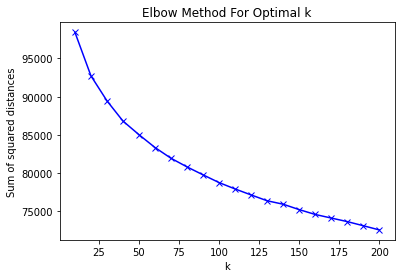

In [384]:
plot_kmeans(K,wvec_ssd,"elbow")

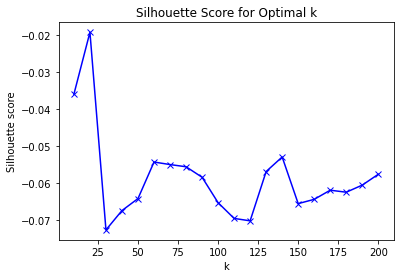

In [385]:
plot_kmeans(K,wvec_silhouette,"silhouette")

Assign labels and centroids to separate variables for later use.

#### 2.5.2 T-SNE + Kmeans

In [213]:
method='barnes_hut'
n_components = 2
verbose = 1

In [214]:
E_tsne = TSNE(n_components=n_components, method=method, verbose=verbose).fit_transform(E)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19498 samples in 0.004s...
[t-SNE] Computed neighbors for 19498 samples in 8.615s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19498
[t-SNE] Computed conditional probabilities for sample 2000 / 19498
[t-SNE] Computed conditional probabilities for sample 3000 / 19498
[t-SNE] Computed conditional probabilities for sample 4000 / 19498
[t-SNE] Computed conditional probabilities for sample 5000 / 19498
[t-SNE] Computed conditional probabilities for sample 6000 / 19498
[t-SNE] Computed conditional probabilities for sample 7000 / 19498
[t-SNE] Computed conditional probabilities for sample 8000 / 19498
[t-SNE] Computed conditional probabilities for sample 9000 / 19498
[t-SNE] Computed conditional probabilities for sample 10000 / 19498
[t-SNE] Computed conditional probabilities for sample 11000 / 19498
[t-SNE] Computed conditional probabilities for sample 12000 / 19498
[t-SNE] Computed conditional probabilities for sam

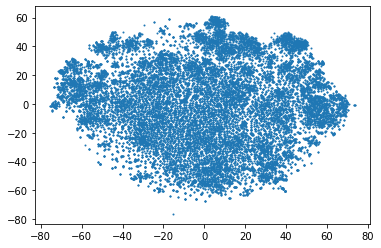

In [215]:
plt.scatter(E_tsne[:, 0], E_tsne[:, 1], s=1);

In [389]:
%%time

tsne_ssd, tsne_silhouette = kmeans_search(E_tsne, K)

For n_clusters = 10 The average silhouette_score is : 0.37478644
For n_clusters = 20 The average silhouette_score is : 0.36666763
For n_clusters = 30 The average silhouette_score is : 0.36414522
For n_clusters = 40 The average silhouette_score is : 0.35804102
For n_clusters = 50 The average silhouette_score is : 0.36096376
For n_clusters = 60 The average silhouette_score is : 0.3575868
For n_clusters = 70 The average silhouette_score is : 0.35891905
For n_clusters = 80 The average silhouette_score is : 0.36087665
For n_clusters = 90 The average silhouette_score is : 0.36161482
For n_clusters = 100 The average silhouette_score is : 0.3613771
For n_clusters = 110 The average silhouette_score is : 0.36354688
For n_clusters = 120 The average silhouette_score is : 0.36354893
For n_clusters = 130 The average silhouette_score is : 0.36461017
For n_clusters = 140 The average silhouette_score is : 0.365778
For n_clusters = 150 The average silhouette_score is : 0.36173385
For n_clusters = 160 Th

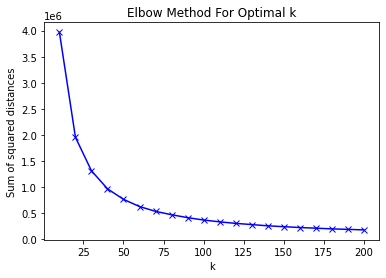

In [390]:
plot_kmeans(K,tsne_ssd,"elbow")

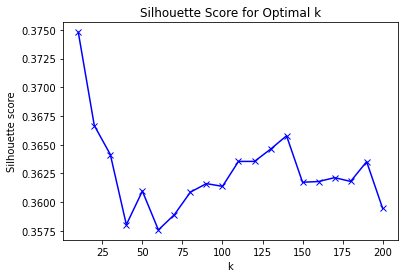

In [391]:
plot_kmeans(K,tsne_silhouette,"silhouette")

#### 2.5.3 PCA + Kmeans

In [216]:
n_components = 0.9
verbose = 1

In [217]:
pca_fit = PCA(n_components = n_components).fit(E)

In [218]:
print(len(pca_fit.explained_variance_ratio_))
print(pca_fit.explained_variance_ratio_)
print(np.sum(pca_fit.explained_variance_ratio_))

179
[0.09085786 0.04430507 0.03889801 0.03021836 0.02840262 0.02468056
 0.02224194 0.02052893 0.01921241 0.01784138 0.01683477 0.0148225
 0.01361958 0.0128309  0.01258834 0.0115836  0.01097102 0.01016251
 0.0097819  0.00954369 0.00887937 0.00867908 0.00824066 0.00811348
 0.0077192  0.00730779 0.00714591 0.00705249 0.00681285 0.00655043
 0.00636942 0.00622914 0.00610005 0.00592972 0.00575623 0.00562367
 0.00544013 0.00528517 0.00526524 0.00500746 0.0049221  0.00485796
 0.00484005 0.00476447 0.00458024 0.00453214 0.00438317 0.00435276
 0.00416083 0.00410721 0.00400744 0.00394602 0.00391809 0.00383531
 0.00373255 0.0036343  0.00354919 0.00349796 0.00343568 0.0033994
 0.0033862  0.00331953 0.00327547 0.00321532 0.00318813 0.00315867
 0.003119   0.00305727 0.00301948 0.00298445 0.00293656 0.00291593
 0.00284899 0.00283848 0.00277709 0.00273183 0.00271985 0.00268629
 0.00266973 0.00262688 0.00256858 0.00254215 0.00252468 0.00250248
 0.00245366 0.00241552 0.00238988 0.00238026 0.00234211 0.00

In [219]:
E_pca = pca_fit.transform(E)

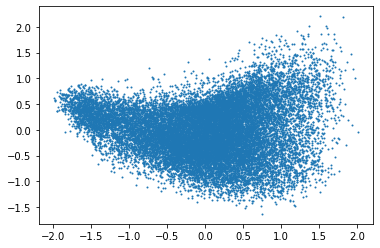

In [220]:
plt.scatter(E_pca[:, 0], E_pca[:, 1], s=1);

In [397]:
%%time

pca_ssd, pca_silhouette = kmeans_search(E_pca, K)

For n_clusters = 10 The average silhouette_score is : -0.022082698
For n_clusters = 20 The average silhouette_score is : -0.004242049
For n_clusters = 30 The average silhouette_score is : -0.04832848
For n_clusters = 40 The average silhouette_score is : -0.042334124
For n_clusters = 50 The average silhouette_score is : -0.04541711
For n_clusters = 60 The average silhouette_score is : -0.029091742
For n_clusters = 70 The average silhouette_score is : -0.04208782
For n_clusters = 80 The average silhouette_score is : -0.033878442
For n_clusters = 90 The average silhouette_score is : -0.039335344
For n_clusters = 100 The average silhouette_score is : -0.03747511
For n_clusters = 110 The average silhouette_score is : -0.04942073
For n_clusters = 120 The average silhouette_score is : -0.04341687
For n_clusters = 130 The average silhouette_score is : -0.041762803
For n_clusters = 140 The average silhouette_score is : -0.03971628
For n_clusters = 150 The average silhouette_score is : -0.038378

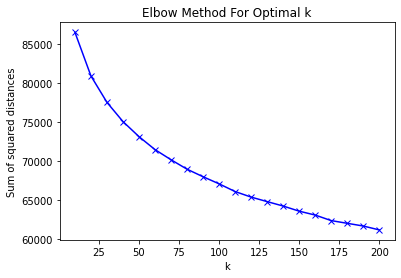

In [398]:
plot_kmeans(K,pca_ssd,"elbow")

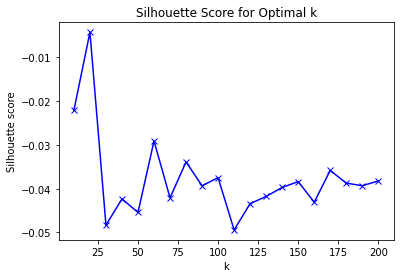

In [399]:
plot_kmeans(K,pca_silhouette,"silhouette")

#### 2.5.4 UMAP + Kmeans

In [221]:
%%time

metric = 'cosine'
dm = cdist(E, E, metric)
np.fill_diagonal(dm, 0)

CPU times: user 2min 12s, sys: 3.28 s, total: 2min 15s
Wall time: 2min 18s


In [222]:
is_valid_dm(dm)

True

In [223]:
mean, std = np.mean(dm), np.std(dm)
print(mean, std)

0.5925560692136862 0.14890877456877802


In [224]:
min_dist=mean - 2*std
n_neighbors = int(0.001*len(E))
n_components=2
print(f"Min distance: {min_dist}")
print(f"N. neighbors: {n_neighbors}")
print(f"N. compontents: {n_components}")

Min distance: 0.29473852007613016
N. neighbors: 19
N. compontents: 2


In [225]:
%%time

E_umap = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
    verbose=verbose
).fit_transform(E)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.29473852007613016,
     n_neighbors=19, random_state=42, verbose=1)
Construct fuzzy simplicial set
Thu Aug  5 12:36:27 2021 Finding Nearest Neighbors
Thu Aug  5 12:36:27 2021 Building RP forest with 12 trees
Thu Aug  5 12:36:28 2021 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Thu Aug  5 12:36:30 2021 Finished Nearest Neighbor Search
Thu Aug  5 12:36:30 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Aug  5 12:36:45 2021 Finished embedding
CPU times: user 21.9 s, sys: 2.9 s, total: 24.8 s
Wall time: 18.5 s


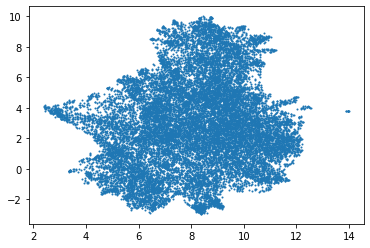

In [226]:
plt.scatter(E_umap[:, 0], E_umap[:, 1], s=1);

In [438]:
%%time

umap_ssd, umap_silhouette = kmeans_search(E_umap, K)

For n_clusters = 10 The average silhouette_score is : 0.351182
For n_clusters = 20 The average silhouette_score is : 0.35603577
For n_clusters = 30 The average silhouette_score is : 0.36309338
For n_clusters = 40 The average silhouette_score is : 0.35398746
For n_clusters = 50 The average silhouette_score is : 0.34627366
For n_clusters = 60 The average silhouette_score is : 0.34752306
For n_clusters = 70 The average silhouette_score is : 0.3474978
For n_clusters = 80 The average silhouette_score is : 0.34946468
For n_clusters = 90 The average silhouette_score is : 0.35045117
For n_clusters = 100 The average silhouette_score is : 0.34772164
For n_clusters = 110 The average silhouette_score is : 0.3505882
For n_clusters = 120 The average silhouette_score is : 0.3454415
For n_clusters = 130 The average silhouette_score is : 0.34700733
For n_clusters = 140 The average silhouette_score is : 0.34971148
For n_clusters = 150 The average silhouette_score is : 0.3476493
For n_clusters = 160 The 

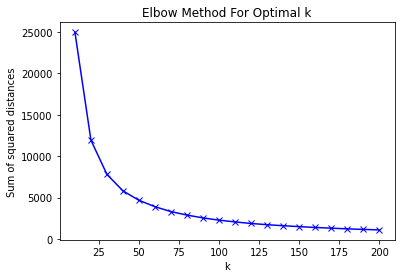

In [439]:
plot_kmeans(K,umap_ssd,"elbow")

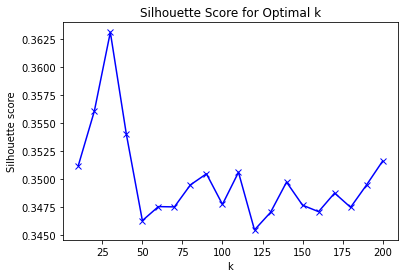

In [440]:
plot_kmeans(K,umap_silhouette,"silhouette")

#### 2.5.5 Choose clustering model

In [227]:
k_base = 100
k_pca = k_base
k_tsne = k_base
k_umap = k_base

In [228]:
%%time

km_base = cluster.KMeans(n_clusters=k_base,max_iter=300).fit(E)
labels = km_base.labels_
centroids = km_base.cluster_centers_

km_pca = cluster.KMeans(n_clusters=k_pca,max_iter=300).fit(E_pca)
labels_pca = km_pca.labels_

km_tsne = cluster.KMeans(n_clusters=k_tsne,max_iter=300).fit(E_tsne)
labels_tsne = km_tsne.labels_

km_umap = cluster.KMeans(n_clusters=k_umap,max_iter=300).fit(E_umap)
labels_umap=km_umap.labels_

CPU times: user 3min 36s, sys: 29.6 s, total: 4min 6s
Wall time: 54.6 s


Create an index that maps each word to a cluster.

In [229]:
word2cluster = {features[idx]: cl for idx, cl in enumerate(labels)}

In [230]:
print(take(10, word2cluster.items()))

[('[', 37), (']', 56), ('^', 37), ('_____', 37), ('aa_bowl', 53), ('aaaaaand', 4), ('aaron', 94), ('aarp', 42), ('abandoned', 26), ('abandoning', 75)]


Now, conversely, create an index that maps each cluster to a word.

In [231]:
cluster2words = defaultdict(list)
for key, value in word2cluster.items():
    cluster2words[value].append(key)

In [232]:
print(len(cluster2words[0]))
print(cluster2words[0][:100])

97
['actor', 'alibi', 'anime', 'artist', 'attendance', 'audio', 'ballad', 'band', 'band_playing', 'beyonc', 'blast', 'cartoon', 'cast', 'celebrity', 'circus', 'cirque', 'club', 'comedy_club', 'concert', 'cover_charge', 'crowd', 'dance', 'dance_club', 'danced', 'dancefloor', 'dancer', 'dancing', 'dj', 'documentary', 'drum', 'duet', 'entertained', 'entertaining', 'entertainment', 'era', 'film', 'filmed', 'front_row', 'genre', 'grateful_dead', 'groove', 'guitar', 'halloween', 'harry_potter', 'hilarious', 'hip_hop', 'hip_hop_music', 'horror_movie', 'instrument', 'interactive', 'jazz', 'jazzy', 'karaoke', 'kj', 'live_band', 'live_jazz', 'live_music', 'mic', 'movie', 'music', 'nightclub', 'old_school', 'open_mic', 'performance', 'performing', 'piano', 'play', 'played', 'played_song', 'playing', 'playing_guitar', 'prince', 'production', 'punchline', 'r_b', 'rap_music', 'rnb', 'rocking', 'sang', 'serenaded', 'sex_city', 'show', 'sing', 'singing', 'singing_along', 'soleil', 'song', 'sound_syste

In [233]:
print(len(cluster2words[1]))
print(cluster2words[1][:100])

74
['airplane', 'airport', 'alaska', 'atl_airport', 'atlanta_hartsfield', 'broadway_cab', 'bus', 'bus_ride', 'buy_ticket', 'cab', 'cab_company', 'cab_driver', 'carrier', 'catch_flight', 'catching_flight', 'commuter', 'concourse', 'connecting', 'connection', 'delayed', 'delta_airline', 'departure', 'departure_gate', 'destination', 'driver', 'easy_navigate', 'en_route', 'flew', 'flight', 'flight_attendant', 'flown', 'fly', 'flying', 'frequent_flyer', 'frequent_traveler', 'gate', 'hartsfield', 'hour_layover', 'international', 'international_flight', 'jet', 'landed', 'landing', 'lax', 'layover', 'layover_atlanta', 'luggage', 'lyft', 'ord', 'passport', 'pilot', 'plane', 'rental_car', 'ride', 'riding', 'rode', 'round_trip', 'route', 'runway', 'security', 'southwest', 'stuck_traffic', 'terminal', 'terminal_f', 'train', 'transit', 'transport', 'transportation', 'travel', 'traveling', 'trimet', 'uber', 'uber_driver', 'wheelchair']


### 2.6 Initialize documents

Transform all reviews into "documents", each with a set of weights per word in the corpus ("nbow"), the sum of these weights ("weights_sum"), the indeces of the words in the documents ("idxs") and the word vectors corresponding to each word ("vecs").

In [234]:
pos_nbow[0]

<1x19498 sparse matrix of type '<class 'numpy.float64'>'
	with 76 stored elements in Compressed Sparse Row format>

In [235]:
%%time 

pos_docs, neg_docs = [], []

for idx, doc in enumerate(pos_tok):
    pos_docs.append(Document(doc, pos_nbow[idx], word2idx, E, idx))
    
for idx, doc in enumerate(neg_tok):
    neg_docs.append(Document(doc, neg_nbow[idx], word2idx, E, idx))

CPU times: user 1.58 s, sys: 926 ms, total: 2.51 s
Wall time: 3.21 s


In [236]:
pos_docs[0].nbow

array([[0.00234907, 0.00234907, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [237]:
pos_docs[0].weights_sum

1.0000000000000004

In [238]:
pos_docs[0].idxs[:10]

[0, 12928, 4864, 4995, 14976, 17409, 12416, 10626, 1, 4361]

In [239]:
pos_docs[0].vecs[:1][0][:10]

array([ 0.15857954, -0.15556984, -0.0054978 , -0.1308413 , -0.01429296,
       -0.12834749,  0.11757544,  0.13080046,  0.03922231,  0.3269623 ],
      dtype=float32)

### 2.7 Linear-Complexity Relaxed WMD (LC-RWMD)

Run the [Linear-Complexity Relaxed WMD](https://arxiv.org/abs/1711.07227) to get the distances between all positive and all negative reviews.

In [240]:
metric = "euclidean"

In [241]:
lc_rwmd = LC_RWMD(pos_docs, neg_docs,pos_nbow,neg_nbow,E)

In [242]:
%time lc_rwmd.get_D(metric=metric)
#%time lc_rwmd.get_L(1)
#%time lc_rwmd.get_rwmd()

CPU times: user 33min 46s, sys: 16min 29s, total: 50min 16s
Wall time: 14min 30s


### 2.8 Gale-Shapeley Pairing

Use the [Gale-Shapeley matching algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) to find the optimal pairs between positive and negative reviews. This iterates over all the reviews and finds the set of matches that pairs each review with its optimal match given that all positive reviews have to be matched with a negative review and vice versa. The output is a dictionary of key-value pairs, where each pair represents an optimal match.

In [243]:
# Options: 'gale_shapeley','random','full'

pairing = 'gale_shapeley'

In [244]:
%%time

if pairing == 'gale_shapeley':
    print("Running Gale-Shapeley pairing.")
    matcher = Matcher(lc_rwmd.D)
    engaged = matcher.matchmaker()
    matcher.check()
    pairs = [(k, v) for k, v in engaged.items()]
    #pairs = engaged
if pairing == 'random':
    print("Running random pairing.")
    pos_idx = list(range(0,len(pos_docs)))
    neg_idx = list(range(0,len(neg_docs)))
    shuffle(pos_idx)
    shuffle(neg_idx)
    pairs = zip(pos_idx, neg_idx)
if pairing == 'full':
    print("Running full pairing.")
    pos_idx = list(range(0,len(pos_docs)))
    neg_idx = list(range(0,len(neg_docs)))
    pairs = [(i,j) for i in pos_idx for j in neg_idx]
    #pos_docs = [d for d in pos_docs for _ in list(range(0,len(neg_docs)))]
    #neg_docs = [d for d in neg_docs for _ in list(range(0,len(pos_docs)))]

Running Gale-Shapeley pairing.
CPU times: user 20.9 s, sys: 1.77 s, total: 22.7 s
Wall time: 25.1 s


Let's look at the output of Gale-Shapeley:

In [245]:
print(pairs[:20])

[(0, 806), (1, 1308), (300, 741), (100, 515), (1413, 1290), (1200, 1496), (120, 1218), (30, 722), (1004, 1572), (1657, 1978), (1481, 1736), (1367, 1164), (465, 28), (1009, 1609), (641, 370), (1010, 1633), (408, 507), (1379, 1945), (1592, 1712), (1580, 1867)]


In [246]:
example_pairs = [(' '.join(word for word in pos_docs[p[0]].words), 
                  ' '.join(word for word in neg_docs[p[1]].words))
                 for p in pairs]

In [247]:
example_pairs[9][0]

'[ love salmon salad fresh tasty chip_salsa white cheese amazing sangria decent nacho far incredible friend loved burrito rice_bean staff super fast sending food manager made u feel home checking u striking funny conversation restaurant one favorite highly_recommend ]'

In [248]:
example_pairs[9][1]

'[ uninspired kitchen making min wait nd round seating reservation taken worth wait despite great wait staff alcohol option place longed quite time ordered chef course tasting omakase preference leaning away uni scallop served primarily slice fish innovative coupling even usual micro_green house chili garlic oil would welcome rice dry sparse fish piece also weird receiving albacore_tuna couple time wanted primarily nigiri would selected cut never tomago presented consider gauge sushi bar would loved eel well ]'

In [249]:
len(pairs)

2000

### 2.9 Pairwise WMD with Baseline Kmeans

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm _without_ returning the flow between individual words.

In [157]:
%%time 

wmd_pairs = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word, metric=metric)
wmd_pairs.get_distances(thread=False,relax=False)

Calculated distances between approximately 0 documents.00h00m00s elapsed.
CPU times: user 39.1 s, sys: 4.82 s, total: 43.9 s
Wall time: 14.4 s


The return value is a matrix of distances between the document pairs.

In [474]:
np.max(wmd_pairs.distances)

3.459571953480627

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm, this time also returning the flow between individual words.

In [250]:
%%time 

wmd_pairs_flow = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word, metric=metric)
wmd_pairs_flow.get_distances(return_flow = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = False,
                             relax = False)

Calculated distances between approximately 0 documents.00h00m00s elapsed.
Calculated distances between approximately 1000 documents.00h02m08s elapsed.
CPU times: user 3min 22s, sys: 31.6 s, total: 3min 53s
Wall time: 1min 20s


Now we have three return values.

The first one is again a matrix of distances between the document pairs.

In [251]:
np.max(wmd_pairs_flow.distances)

4.251672087687845

The second return value is a list of tuples with all the words that contributed the most to the distance from the positive documents to the negative ones. These are _not_ sorted from high to low or vice versa.

In [252]:
take(10, wmd_pairs_flow.wc_X1.items())

[('seasoned_perfection', 0.24040999999999998),
 ('skin_rash', 0.09764),
 ('voodoo_doll', 0.12202),
 ('strength', 0.34069000000000005),
 ('patriarchy', 0.048679999999999994),
 ('cool', 4.467529999999998),
 ('chpt', 0.36633000000000004),
 ('fichadia', 0.05477),
 ('carb', 0.05297),
 ('especailly', 0.20220000000000002)]

The third return value is a list of tuples with all the words that contributed the most to the distance from the negative documents to the positive ones. Again, these are _not_ sorted from high to low or vice versa.

In [253]:
take(10, wmd_pairs_flow.wc_X2.items())

[('strand_hair', 0.07417),
 ('dr_bootstaylor', 0.043840000000000004),
 ('strength', 0.18347999999999998),
 ('cool', 0.75659),
 ('regina', 0.27648),
 ('pet_sitter', 0.03388),
 ('summery', 0.03384),
 ('cheat_sheet', 0.03364),
 ('elliot', 0.01943),
 ('lengthy', 0.08423)]

In [254]:
take(10, wmd_pairs_flow.cc_X1.items())

[(37, 92.58577999999996),
 (56, 263.0988600000001),
 (53, 36.15221),
 (4, 25.16280999999998),
 (94, 65.63384999999997),
 (42, 9.690300000000002),
 (26, 69.7972300000001),
 (75, 83.35989999999997),
 (72, 78.37432999999997),
 (95, 651.3335799999985)]

In [255]:
take(10, wmd_pairs_flow.cc_X2.items())

[(37, 137.96155999999985),
 (56, 85.81952000000005),
 (53, 19.145320000000005),
 (4, 36.072500000000026),
 (94, 35.027599999999985),
 (42, 38.17433999999995),
 (26, 121.59064000000009),
 (75, 114.93288000000004),
 (72, 12.537999999999997),
 (95, 312.6453400000012)]

In [256]:
{k: v for k, v in sorted(wmd_pairs_flow.cc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{95: 651.3335799999985,
 63: 498.48445999999905,
 93: 344.8115400000003,
 56: 263.0988600000001,
 46: 216.88395999999952,
 68: 204.46488000000028,
 39: 159.62511999999984,
 43: 156.20131999999995,
 58: 154.79788,
 28: 133.7786899999998}

In [257]:
wmd_pairs_flow.get_differences()

### 3.1 Intepreting pairwise WMD flows

Now, let's sort the distances of the words that created the most distance from the positive to the negative reviews.

In [259]:
top_words_x1 = {k: v for k, v in sorted(wmd_pairs_flow.wc_X1_diff.items(), key=lambda item: item[1], reverse=True)[:30]}
top_words_x1_df = pd.DataFrame.from_dict(top_words_x1, orient='index', columns = ["cost"])
top_words_x1_df.cost = top_words_x1_df.cost.round(2)
top_words_x1_df

,cost
great,41.79
best,33.15
amazing,31.35
love,27.71
friendly,27.02
delicious,26.18
highly_recommend,24.93
staff,19.96
definitely,19.52
always,18.68


Next, let's see what added most distance when moving from the negative to the positive reviews.

In [270]:
top_words_x2 = {k: v for k, v in sorted(wmd_pairs_flow.wc_X2_diff.items(), key=lambda item: item[1], reverse=True)[:30]}
top_words_x2_df = pd.DataFrame.from_dict(top_words_x2, orient='index', columns = ["cost"])
top_words_x2_df.cost = top_words_x2_df.cost.round(2)
top_words_x2_df



,cost
told,19.64
order,19.58
rude,18.10
never,17.94
worst,17.44
minute,15.14
hour,14.97
said,14.91
money,13.89
terrible,13.57


Finally, let's look at the distances between the two sets by clustering similar words, in order to get a better sense of what kind of "topics" that separate them. Each cluster has a weight that matches the sum of the words belonging to that cluster. We choose *n* top clusters to inspect. To make the clusters interpretable, we also represent each of them by *m* keywords, selected based on the cost they individually add between the two sets.

In [485]:
n_clusters = 10
n_words = 10

In [486]:
c1 = output_clusters(wc=wmd_pairs_flow.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow.cc_X1.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2 = output_clusters(wc=wmd_pairs_flow.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow.cc_X2.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

Positive to negative clusters.

In [487]:
c1

,56,51,92,76,26,30,33,78,47,88
0,great (30.91),made (3.18),good (7.14),delicious (21.13),spot (8.24),friendly (20.8),professional (9.19),year (4.98),massage (16.45),quality (2.12)
1,best (26.33),felt (2.85),really (5.9),favorite (15.06),place (6.2),staff (14.39),team (6.35),new (2.89),relaxing (3.83),price (1.97)
2,amazing (25.21),soon (2.54),nice (5.87),loved (7.27),town (5.07),everyone (6.24),thorough (3.54),moved (2.77),facial (3.72),worth (1.95)
3,love (21.88),quickly (2.07),well (4.3),fresh (7.24),found (3.77),attentive (5.6),feel_comfortable (3.48),weekly (1.58),spa (3.48),option (1.94)
4,highly_recommend (20.17),hand (1.87),kind (4.27),tasty (4.78),glad (3.36),welcoming (4.06),job (2.84),st (1.03),treatment (3.15),beat (1.74)
5,definitely (15.54),house (1.72),lot (3.38),try (4.7),looking (3.0),accommodating (3.77),work (2.74),year_ago (0.98),brow (2.81),every_penny (1.21)
6,always (15.27),next (1.36),little (3.34),enjoyed (4.43),visit (2.95),pleasant (3.28),care (2.61),first (0.86),gentle (2.47),size (0.95)
7,excellent (12.16),around (1.22),also (2.79),must (4.39),friend (2.62),personable (2.76),efficient (2.27),monthly (0.73),calming (2.32),deal (0.95)
8,thank (10.63),along (1.04),enough (2.29),die (2.95),gem (2.52),smile (2.38),felt_comfortable (2.19),yr (0.71),hot_stone (2.2),plus (0.9)
9,super (10.52),totally (1.04),much (2.0),special (2.53),coming (2.21),met (1.46),grateful (2.08),last_week (0.59),lash (1.57),penny (0.88)


Negative to positive clusters.

In [488]:
c2 

,51,92,44,95,35,52,56,26,78,0
0,never (15.84),like (4.84),order (15.17),worst (14.89),told (16.11),use (3.06),ever (2.14),review (5.09),went (5.2),terrible (11.24)
1,hour (11.77),ok (3.46),minute (12.0),money (11.35),said (11.41),issue (2.41),treat (1.23),disappointed (3.2),closed (4.6),bad (7.88)
2,would (10.22),hard (3.31),waiting (7.83),horrible (9.74),asked (10.94),follow (2.17),unbelievable (0.98),close (2.49),month_later (1.89),awful (7.0)
3,u (7.87),maybe (3.27),table (7.56),customer_service (6.39),manager (9.14),problem (1.9),cannot (0.63),decided (1.6),changed (1.87),poor (6.84)
4,could (6.59),however (2.43),waited (6.24),waste_time (5.66),refused (4.05),frustrating (1.66),allaround (0.28),find (1.3),update (1.85),star (4.98)
5,another (6.41),used (2.41),min (5.72),please (4.4),ask (2.86),need (1.51),every_aspect (0.24),read_review (1.26),day (1.8),slow (4.86)
6,even (6.29),seemed (2.33),sitting (3.8),unless (3.82),asking (2.41),properly (1.48),everyday (0.2),heard (1.24),month_ago (1.68),worse (3.8)
7,nothing (6.06),fine (2.31),waiter (3.71),somewhere_else (3.63),mistake (2.26),multiple (1.27),commend (0.2),opened (0.82),last (1.44),disappointing (3.16)
8,give (5.36),least (2.03),hostess (3.59),avoid (3.56),stated (2.05),due (1.17),speedy (0.16),somewhere (0.63),twice (1.43),sad (2.96)
9,left (5.35),something (1.71),line (3.32),suck (2.5),informed (1.87),failed (1.12),alway (0.13),first_impression (0.62),month (1.23),unfortunately (2.63)


In [491]:
sample.shape

(4000, 21)

In [493]:
x1_costs = pd.DataFrame(wmd_pairs_flow.X1_feat)
x1_costs.index = [p[0] for p in pairs]
x1_costs = x1_costs.sort_index()
x1_costs = x1_costs[c1.columns]
x1_costs['categories'] = sample[:2000].categories

In [494]:
Counter(x1_costs.categories)

Counter({'Health & Medical': 1000, 'Restaurants': 1000})

In [496]:
x1_costs_long = pd.melt(x1_costs, id_vars=['categories']).rename(columns={"variable":"cluster"})
x1_costs_long.head()

,categories,cluster,value
0,Health & Medical,56,7.872019e-02
1,Restaurants,56,2.237806e-01
2,Restaurants,56,1.001827e-01
3,Restaurants,56,1.106436e-01
4,Restaurants,56,2.465860e-09


In [497]:
x1_costs_long = x1_costs_long[x1_costs_long.value != 0]

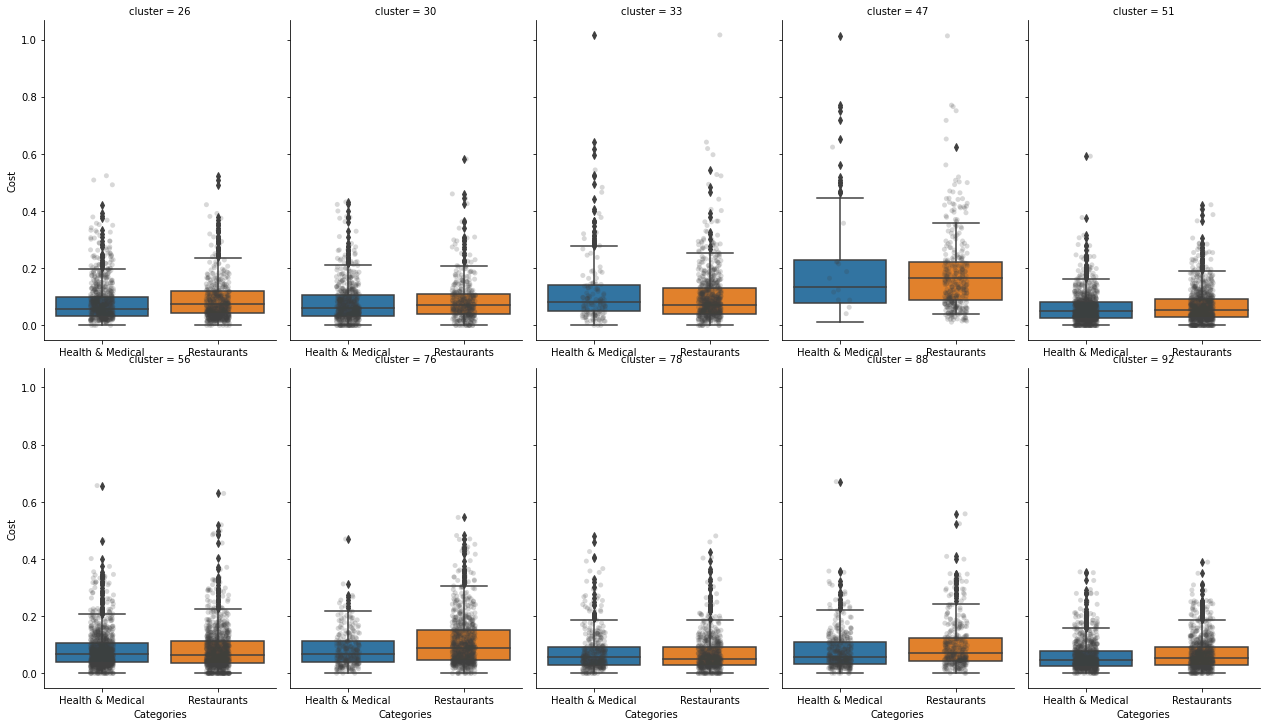

In [498]:
g = sns.catplot(x="categories", 
                y="value", 
                col="cluster", 
                data=x1_costs_long, 
                kind="box",
                height=5, 
                aspect=.7,
                col_wrap=5,
                margin_titles=True);
g.map_dataframe(sns.stripplot, 
                x="categories", 
                y="value", 
                palette=["#404040"], 
                alpha=0.2, dodge=True)
g.set_axis_labels("Category", "Cost")
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)


In [500]:
x2_costs = pd.DataFrame(wmd_pairs_flow.X1_feat)
x2_costs.index = [p[1] for p in pairs]
x2_costs = x2_costs.sort_index()
x2_costs = x2_costs[c2.columns]
x2_costs['categories'] = sample[2000:4000].categories.tolist()

In [501]:
x2_costs_long = pd.melt(x2_costs, id_vars=['categories']).rename(columns={"variable":"cluster"})
x2_costs_long.head()

,categories,cluster,value
0,Restaurants,51,7.013432e-02
1,Restaurants,51,6.732291e-02
2,Restaurants,51,1.714822e-02
3,Restaurants,51,5.464382e-02
4,Restaurants,51,3.644711e-09


In [925]:
x2_costs_long = x2_costs_long[x2_costs_long.value != 0]

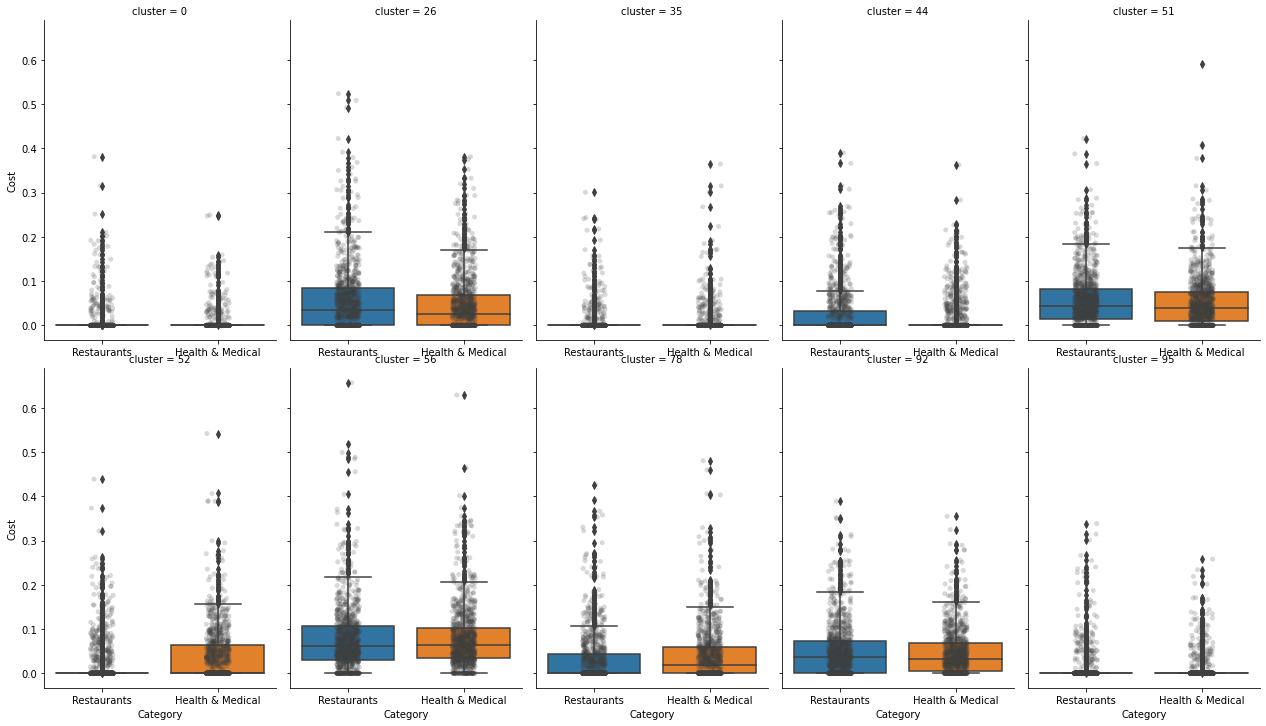

In [502]:
g = sns.catplot(x="categories", 
                y="value", 
                col="cluster", 
                data=x2_costs_long, 
                kind="box",
                height=5, 
                aspect=.7,
                col_wrap=5,
                margin_titles=True);
g.map_dataframe(sns.stripplot, 
                x="categories", 
                y="value", 
                palette=["#404040"], 
                alpha=0.2, dodge=True)
g.set_axis_labels("Category", "Cost")
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)


## 4 Better clusters with UMAP and T-SNE

#### 4.1 UMAP + Kmeans

In [118]:
word2cluster_u = {features[idx]: cl for idx, cl in enumerate(labels_umap)}

In [119]:
print(take(10, word2cluster_u.items()))

[(']', 84), ('^_', 49), ('`', 4), ('aaargh', 3), ('aaliyah', 8), ('aamir_khan', 54), ('aaron', 13), ('aaron_eckhart', 18), ('ab_tak', 93), ('abandon', 92)]


Now, conversely, create an index that maps each cluster to a word.

In [120]:
cluster2words_u = defaultdict(list)
for key, value in word2cluster_u.items():
    cluster2words_u[value].append(key)

In [121]:
%%time 

wmd_pairs_flow_u = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow_u.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_u, 
                               c2w = cluster2words_u,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 2min 3s, sys: 15.9 s, total: 2min 19s
Wall time: 1min 13s


In [123]:
wmd_pairs_flow_u.get_differences()

In [125]:
c1_u = output_clusters(wc=wmd_pairs_flow_u.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow_u.cc_X1.items(), 
                     c2w=cluster2words_u, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2_u = output_clusters(wc=wmd_pairs_flow_u.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow_u.cc_X2.items(), 
                     c2w=cluster2words_u, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

In [126]:
c1_u

,38,65,48,50,6,45,78,16,14,68
0,great (2.48),loved (1.27),game (1.77),dvd (0.7),still (1.8),year (0.8),film (0.68),little (1.23),performance (1.36),story (0.7)
1,best (2.03),enjoy (0.72),hard (0.42),show (0.4),disney (0.89),new (0.67),although (0.37),entertaining (0.66),role (0.9),quality (0.3)
2,excellent (1.42),well_worth (0.67),cartoon (0.18),hope (0.39),every (0.34),night (0.43),cinema (0.36),hilarious (0.5),star (0.55),quite (0.3)
3,wonderful (1.3),want (0.42),people (0.16),channel (0.37),compared (0.19),day (0.39),hollywood (0.22),comedy (0.43),play (0.46),edge_seat (0.23)
4,song (0.96),check (0.25),segal (0.15),found (0.34),taste (0.19),old (0.38),though (0.18),plus (0.32),playing (0.39),build (0.23)
5,brilliant (0.83),liked (0.23),meatball (0.14),buy (0.33),much (0.16),lived (0.35),throughout (0.17),fulci (0.3),great_job (0.31),clever (0.23)
6,perfect (0.75),enjoyed (0.21),animated (0.14),glad (0.31),one (0.15),late (0.33),filled (0.17),humor (0.28),hamlet (0.2),bit (0.23)
7,beautiful (0.68),would_recommend (0.19),subtitle (0.14),film_festival (0.27),sf (0.14),memory (0.29),pure (0.14),martial_art (0.26),davy (0.19),romantic_comedy (0.22)
8,soundtrack (0.67),seen (0.17),serial (0.13),first_saw (0.25),eighty (0.14),grew (0.25),part (0.12),enjoyable (0.23),rest_cast (0.18),extremely (0.19)
9,amazing (0.65),thought (0.17),exactly (0.13),video (0.25),perhaps (0.13),last (0.25),dated (0.11),humour (0.21),supporting_cast (0.18),suspenseful (0.13)


In [127]:
c2_u

,65,48,56,6,30,16,63,50,78,77
0,movie (2.33),would (0.5),bad (5.31),even (1.48),worst (2.48),stupid (1.61),better (1.0),came (0.35),director (0.41),supposed (0.74)
1,really (0.94),reason (0.47),plot (1.52),could (1.22),ever_seen (0.95),funny (0.87),least (0.77),fox (0.31),effort (0.34),case (0.52)
2,rating (0.84),going (0.46),boring (1.38),instead (1.03),one_worst (0.88),joke (0.76),nothing (0.76),sat (0.31),seems (0.27),making (0.43)
3,say (0.72),gave (0.42),awful (1.34),made (0.83),ever (0.74),idiotic (0.39),ok (0.63),episode (0.31),numerous (0.27),understand (0.39)
4,rent (0.7),basically (0.42),terrible (1.24),enough (0.72),hour (0.74),unrealistic (0.37),cheap (0.6),finished (0.28),point (0.27),obviously (0.36)
5,maybe (0.61),never (0.4),poor (1.12),idea (0.59),minute (0.72),lot (0.37),anything (0.56),picked (0.27),contain (0.19),project (0.27)
6,anyone (0.61),wrong (0.4),horrible (0.93),either (0.46),worse (0.72),overall (0.32),sequel (0.43),series (0.25),example (0.18),sort (0.26)
7,watching (0.52),happen (0.39),script (0.7),rest (0.45),something (0.68),nudity (0.29),whole_thing (0.42),blockbuster (0.25),almost (0.15),fact (0.26)
8,review (0.52),tried (0.37),dialog (0.63),make_sense (0.45),waste (0.65),serious (0.28),b (0.41),rented (0.21),shocking (0.15),blame (0.25)
9,recommend (0.48),like (0.37),dull (0.6),producer (0.36),waste_time (0.61),disgusting (0.28),expect (0.39),went_see (0.21),columbo (0.14),confused (0.25)


#### 4.1 T-SNE + Kmeans

In [128]:
word2cluster_t = {features[idx]: cl for idx, cl in enumerate(labels_tsne)}

In [129]:
print(take(10, word2cluster_t.items()))

[(']', 65), ('^_', 25), ('`', 45), ('aaargh', 79), ('aaliyah', 39), ('aamir_khan', 56), ('aaron', 84), ('aaron_eckhart', 20), ('ab_tak', 54), ('abandon', 74)]


Now, conversely, create an index that maps each cluster to a word.

In [139]:
cluster2words_t = defaultdict(list)
for key, value in word2cluster_t.items():
    cluster2words_t[value].append(key)

In [141]:
%%time 

wmd_pairs_flow_t = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow_t.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_t, 
                               c2w = cluster2words_t,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 2min 5s, sys: 14.9 s, total: 2min 20s
Wall time: 1min 16s


In [142]:
wmd_pairs_flow_t.get_differences()

In [143]:
c1_t = output_clusters(wc=wmd_pairs_flow_t.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow_t.cc_X1.items(), 
                     c2w=cluster2words_t, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2_t = output_clusters(wc=wmd_pairs_flow_t.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow_t.cc_X2.items(), 
                     c2w=cluster2words_t, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

In [144]:
c1_t

,92,67,86,48,99,87,10,31,17,95
0,loved (1.27),great (2.48),disney (0.89),thought (0.17),game (1.77),performance (1.36),dvd (0.7),real (0.65),feeling (0.6),year (0.8)
1,time (0.84),excellent (1.42),film (0.68),people (0.16),hilarious (0.5),role (0.9),hope (0.39),often (0.4),feel (0.54),night (0.43)
2,well_worth (0.67),wonderful (1.3),entertaining (0.66),exactly (0.13),comedy (0.43),star (0.55),channel (0.37),moving (0.35),message (0.43),day (0.39)
3,fan (0.55),song (0.96),definitely (0.54),folk (0.12),scifi (0.43),play (0.46),found (0.34),filmed (0.21),reality (0.34),lived (0.35)
4,wish (0.28),brilliant (0.83),special (0.39),shocked (0.11),show (0.4),playing (0.39),buy (0.33),top (0.17),theme (0.3),memory (0.29)
5,liked (0.23),perfect (0.75),cinema (0.36),happy_ending (0.11),humor (0.28),great_job (0.31),glad (0.31),main (0.15),issue (0.21),future (0.26)
6,enjoyed (0.21),beautiful (0.68),particularly (0.35),wanting (0.09),short (0.24),usual (0.25),film_festival (0.27),character (0.15),society (0.18),grew (0.25)
7,seen (0.17),soundtrack (0.67),classic (0.33),figured (0.08),clever (0.23),rest_cast (0.18),first_saw (0.25),segment (0.13),importance (0.17),last (0.25)
8,buy_copy (0.16),amazing (0.65),work (0.33),running_time (0.08),humour (0.21),supporting_cast (0.18),video (0.25),sequence (0.13),complex (0.16),took (0.22)
9,really_liked (0.16),incredible (0.59),highly_recommend (0.28),cared (0.08),one_liner (0.17),shine (0.17),theater (0.21),edited (0.11),dealing (0.16),weekend (0.21)


In [145]:
c2_t

,28,92,48,89,49,19,31,42,82,86
0,bad (5.31),movie (2.33),hour (0.74),worst (2.48),even (1.48),really (0.94),shot (0.67),could (1.22),made (0.83),better (1.0)
1,stupid (1.61),rating (0.84),minute (0.72),ever_seen (0.95),enough (0.72),maybe (0.61),scene (0.54),instead (1.03),supposed (0.74),original (0.33)
2,plot (1.52),say (0.72),anyone (0.61),one_worst (0.88),idea (0.59),mean (0.42),camera (0.51),least (0.77),making (0.43),overall (0.32)
3,boring (1.38),watching (0.52),bored (0.58),ever (0.74),premise (0.45),guess (0.38),numerous (0.27),nothing (0.76),wrong (0.4),serious (0.28)
4,awful (1.34),review (0.52),end (0.5),rent (0.7),disappointing (0.36),like (0.37),main_character (0.27),anything (0.56),line (0.27),produced (0.14)
5,terrible (1.24),reason (0.47),depressing (0.49),something (0.68),producer (0.36),someone (0.35),echo (0.19),either (0.46),meant (0.17),standard (0.08)
6,poor (1.12),disappointed (0.34),actually (0.47),waste (0.65),unfortunately (0.35),seriously (0.32),example (0.18),gave (0.42),looking (0.17),bollywood (0.08)
7,horrible (0.93),comment (0.34),going (0.46),waste_time (0.61),stereotype (0.29),anymore (0.26),relentlessly (0.17),laugh (0.34),ruin (0.15),worked (0.07)
8,worse (0.72),saying (0.33),make_sense (0.45),ever_made (0.56),seems (0.27),hate (0.24),clip (0.16),cool (0.32),appeal (0.13),equally (0.07)
9,dialog (0.63),hated (0.32),seemed (0.45),recommend (0.48),project (0.27),hell (0.24),particular (0.16),seagal (0.29),describe (0.12),dubbed (0.07)


## 5 Reduced Dimension Inputs

### 5.1 UMAP

In [ ]:
### TODO: lcwmd with UMAP

In [170]:
%%time 

wmd_pairs_flow_uvecs = WMDPairs(pos_docs,neg_docs,pairs,E_umap,idx2word)
wmd_pairs_flow_uvecs.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_u, 
                               c2w = cluster2words_u,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 1min 34s, sys: 4.71 s, total: 1min 39s
Wall time: 1min 30s


### 5.2 T-SNE

## Appendix: Many-to-many WMD

This was a first attempt to do the flows from words between many documents, without first filtering using Gale-Shapeley. However, this proved too inefficient. As you can see looking at the CPU times, it is very slow even with extremely small samples and the time complexity is quadratic (or worse?), meaning it rapidly gets even worse as the sample size increases.

In [155]:
%time m2m_distances = WMDManyToMany(pos_docs[:20], neg_docs[:20],E,idx2word).get_distances(return_flow = False)

CPU times: user 1min 48s, sys: 12.7 s, total: 2min 1s
Wall time: 50 s


In [156]:
%time m2m_distances_flow, wc_X1, wc_X2 = WMDManyToMany(pos_docs[:20],neg_docs[:20],E,idx2word).get_distances(return_flow = True)

CPU times: user 1min 52s, sys: 13.5 s, total: 2min 5s
Wall time: 51.4 s


In [157]:
{k: v for k, v in sorted(wc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{'karen': 8.69223,
 'wrenching': 8.31882,
 'carpenter': 7.468960000000001,
 'laughter': 7.467879999999999,
 'liked': 6.864090000000003,
 'mom': 6.791519999999999,
 'gut': 6.759419999999999,
 'love': 6.551409999999997,
 'camp': 6.533080000000001,
 'hr': 6.1393699999999995}

In [158]:
{k: v for k, v in sorted(wc_X2.items(), key=lambda item: item[1], reverse=True)[:10]}

{'hopper': 8.372459999999998,
 'jake': 7.63837,
 'movie': 7.267059999999995,
 'film': 6.936379999999998,
 'shakespeare': 5.99276,
 'oddness': 5.53033,
 'terrible': 4.943440000000001,
 'parent': 4.751790000000001,
 'actor': 4.672620000000001,
 'bad': 4.430020000000002}